In [377]:
# import os
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [378]:
# %pip install lightgbm
# %pip install seaborn
# %pip install Prophet

In [379]:
#information on holiday dataset

holidays = pd.read_csv('/home/ec2-user/SageMaker/Datasets/holidays_events.csv')
sorted_hols = holidays.sort_values(['date', 'locale'])
del holidays
sorted_hols = sorted_hols.drop_duplicates(subset=['date'], keep='last')

#information on stores dataset
stores = pd.read_csv('/home/ec2-user/SageMaker/Datasets/stores.csv')

In [380]:
train = pd.read_csv('/home/ec2-user/SageMaker/Datasets/train.csv', index_col='id')
temp = train.merge(stores, on='store_nbr', how='left')

In [381]:
National_holidays = sorted_hols.loc[sorted_hols['locale'] == 'National'].drop(['locale_name','locale'], axis='columns')
# National_holidays.head()
Regional_holidays = sorted_hols.loc[sorted_hols['locale'] == 'Regional'].drop(['locale'], axis='columns')
# Regional_holidays.head()
Local_holidays = sorted_hols.loc[sorted_hols['locale'] == 'Local'].drop(['locale'], axis='columns')
# Local_holidays.head()

In [382]:
Local_holidays.shape
National_holidays = National_holidays.reset_index(drop=True)
Regional_holidays = Regional_holidays.reset_index(drop=True)
Local_holidays = Local_holidays.reset_index(drop=True)

In [383]:
test = temp.merge(National_holidays, how='left', on='date')
test = test.dropna()

In [384]:
test1 = temp.merge(Regional_holidays, how='right', left_on=['date','state'],right_on=['date', 'locale_name'])
test1 = test1.dropna()
test1 = test1.drop(['locale_name'], axis='columns')

In [385]:
test2 = temp.merge(Local_holidays, how='right', left_on=['date','city'],right_on=['date', 'locale_name'])
test2 = test2.dropna()
test2 = test2.drop(['locale_name'], axis='columns')

In [386]:
array = [test, test1, test2]
result = pd.concat(array)


In [387]:
del test
del test1
del test2
del array

In [388]:
result = result.rename(columns={"type_x": "type", "type_y": "holiday_type"})

In [389]:
cols = list(temp.columns)

In [390]:
output = temp.merge(result, how='left', on=cols)


In [391]:
del temp
del cols

In [392]:
# output.to_csv('/home/ec2-user/SageMaker/Datasets/formatted.csv')

In [393]:
output['ds'] = output.date
output['y'] = output.sales
output = output.loc[output.store_nbr == 50]

# output.date
# output.date.map(lambda d: pd.to_datetime(d))
cols_to_remove = (output.columns)
cols_to_remove = cols_to_remove.drop(['ds','y'])
output.drop(cols_to_remove, axis='columns', inplace=True)

In [394]:
output.ds = pd.to_datetime(output.ds)

In [395]:
output = output.groupby([output.ds.dt.year, output.ds.dt.month])[['y']].sum()

In [396]:
output.index.set_names(['year','month'], inplace=True)
output = output.reset_index()

In [397]:
output.year = output.year.astype(str)
output.month = output.month.astype(str)

In [398]:
output['date'] = output.year
output['date'] = output.date + "-" + output.month
output.drop(['year', 'month'], axis='columns', inplace=True)

In [399]:
output['date'] = pd.DatetimeIndex(output['date'])
output = output.rename(columns={'date': 'ds'})

In [400]:
# output.to_csv('/home/ec2-user/SageMaker/Datasets/check.csv')
output = output.loc[output.ds.dt.year > 2013]

In [401]:
year_split = 2016
temp = output.loc[output.ds.dt.year <= year_split]
train = temp.copy()
del temp
# train.set_index(['store_nbr'],inplace=True)

# s = (train.dtypes == 'object')
# cat_cols = list(s[s].index)
# train[cat_cols] = train[cat_cols].astype('category')

# X = train.copy()
# X.drop(['sales', 'date'], inplace=True, axis='columns')
# # train.head()
# y = train.sales


In [402]:
temp = output[output.ds.dt.year > year_split]
valid = temp.copy()
del temp
# valid.set_index(['store_nbr'],inplace=True)


# s = (valid.dtypes == 'object')
# cat_cols = list(s[s].index)
# valid[cat_cols] = valid[cat_cols].astype('category')

# valid_actual = valid.sales
# valid.drop('y', inplace=True, axis='columns')


In [403]:
m = Prophet(changepoint_prior_scale=0.18)
m.fit(train)


16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing


In [404]:
forecast = m.predict(valid)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
3,2017-04-01,532587.055886,489175.828599,583149.126084
4,2017-05-01,540944.093379,494284.919166,586634.017772
5,2017-06-01,514866.529438,470553.575828,559188.499719
6,2017-07-01,580621.779231,529576.476214,627008.253959
7,2017-08-01,532100.871964,483849.543357,578044.259069


In [405]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,608488.922211,494597.393381,579985.476789,607790.729232,609033.324327,-69353.500545,-69353.500545,-69353.500545,-69353.500545,-69353.500545,-69353.500545,0.0,0.0,0.0,539135.421667
1,2017-02-01,607713.627154,259734.792535,345482.922617,605466.928038,609477.786592,-305976.103911,-305976.103911,-305976.103911,-305976.103911,-305976.103911,-305976.103911,0.0,0.0,0.0,301737.523243
2,2017-03-01,607013.360651,513657.117948,602846.013257,602615.405050,610551.318764,-46985.430211,-46985.430211,-46985.430211,-46985.430211,-46985.430211,-46985.430211,0.0,0.0,0.0,560027.930440
3,2017-04-01,606238.065593,489175.828599,583149.126084,599609.616684,611860.651866,-73651.009707,-73651.009707,-73651.009707,-73651.009707,-73651.009707,-73651.009707,0.0,0.0,0.0,532587.055886
4,2017-05-01,605487.780054,494284.919166,586634.017772,596045.922708,613468.887139,-64543.686675,-64543.686675,-64543.686675,-64543.686675,-64543.686675,-64543.686675,0.0,0.0,0.0,540944.093379
5,2017-06-01,604712.484996,470553.575828,559188.499719,591898.652951,615421.364803,-89845.955558,-89845.955558,-89845.955558,-89845.955558,-89845.955558,-89845.955558,0.0,0.0,0.0,514866.529438
6,2017-07-01,603962.199457,529576.476214,627008.253959,587977.241151,617797.699926,-23340.420226,-23340.420226,-23340.420226,-23340.420226,-23340.420226,-23340.420226,0.0,0.0,0.0,580621.779231
7,2017-08-01,603186.904400,483849.543357,578044.259069,583897.495132,620194.168851,-71086.032436,-71086.032436,-71086.032436,-71086.032436,-71086.032436,-71086.032436,0.0,0.0,0.0,532100.871964


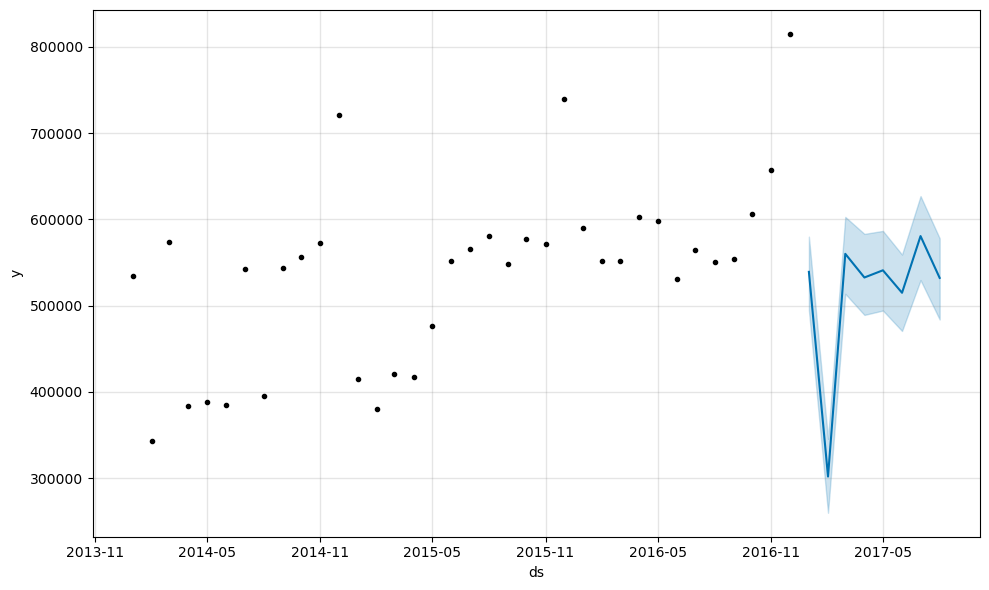

In [406]:
fig1 = m.plot(forecast, uncertainty=True)

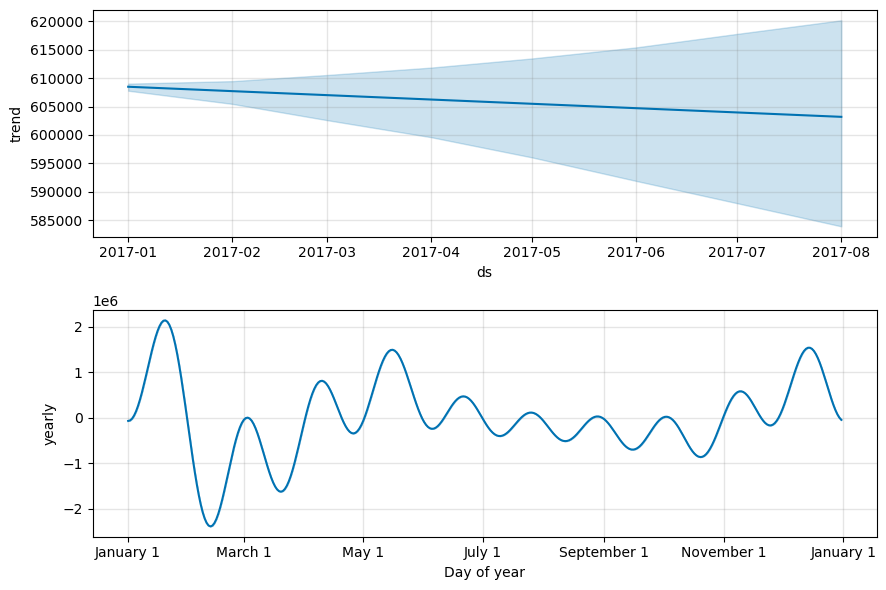

In [407]:
fig2 = m.plot_components(forecast)


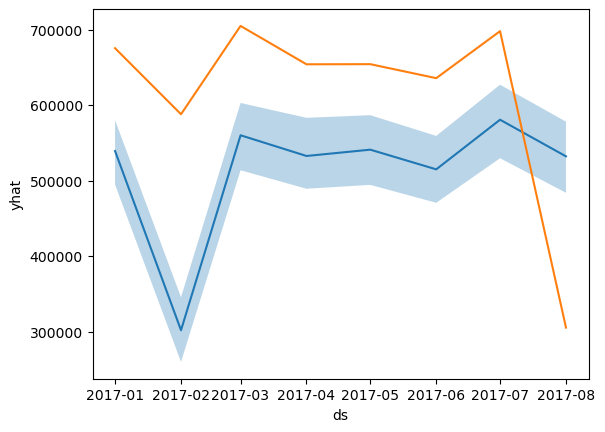

In [408]:
sns.lineplot(data=forecast, x='ds', y='yhat')
# sns.lineplot(data=output, x='ds', y='y')
sns.lineplot(data=valid, x='ds', y='y')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3, label='Confidence Interval')